In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import preprocessing
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

1 Physical GPUs, 1 Logical GPUs


## Non-Cyclic Stocks

In [4]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2001-09-14,7.142585,7.257483,-41.873824,204624213.0,2.0
2001-09-17,7.224180,7.252359,-51.296847,208479649.0,2.0
2001-09-18,7.132634,7.233940,-72.964156,203965392.0,2.0
2001-09-19,7.214230,7.230908,-59.609037,209378730.0,2.0
2001-09-20,7.347568,7.248855,-37.785092,213725440.0,2.0


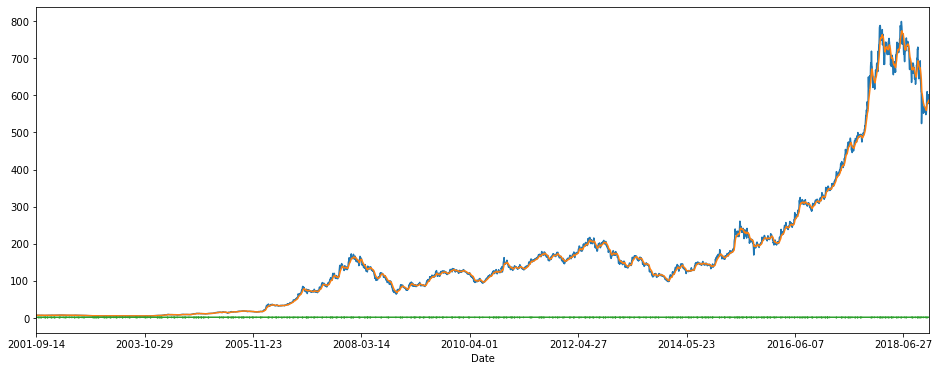

In [5]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [6]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [7]:
willr_data = np.array(willr_data)
willr_data.shape

(4106, 15, 1)

In [8]:
price_data = np.array(price_data)
price_data.shape

(4106, 15, 1)

In [9]:
ema_data = np.array(ema_data)
ema_data.shape

(4106, 15, 1)

In [10]:
obv_data = np.array(obv_data)
obv_data.shape

(4106, 15, 1)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [12]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [13]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000858.SZ_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-24,4.396951,4.259450,-20.237909,91957609.0,2.0
2000-01-25,4.523540,4.300079,-16.033642,115224048.0,2.0
2000-01-26,4.400991,4.315604,-35.231971,105394663.0,2.0
2000-01-27,4.399644,4.328533,-51.735021,77180955.0,2.0
2000-01-28,4.302682,4.324556,-63.091500,43145413.0,2.0


In [15]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [16]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/2319.HK_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2004-06-30,2.575,2.436754,-19.047606,495757896.0,2.0
2004-07-01,2.525,2.450330,-33.333298,480565876.0,2.0
2004-07-02,2.525,2.461818,-33.333298,480565876.0,2.0
2004-07-05,2.550,2.475385,-27.777775,505227876.0,2.0
2004-07-06,2.550,2.486864,-27.777775,505227876.0,2.0


In [17]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [18]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/COST_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,50.0000,47.379245,-27.700831,21139400.0,2.0
2000-01-24,48.5000,47.551669,-40.997230,17619200.0,2.0
2000-01-25,47.0000,47.466797,-54.293629,12613700.0,2.0
2000-01-26,49.6875,47.808444,-30.470914,16344500.0,2.0
2000-01-27,50.4375,48.212914,-27.215190,20127300.0,2.0


In [19]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [20]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/PG_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,56.28125,56.412106,-36.614173,-25968400.0,2.0
2000-01-24,51.34375,55.632359,-83.112583,-50347200.0,2.0
2000-01-25,51.56250,55.006226,-64.721485,-21792600.0,1.0
2000-01-26,48.75000,54.043730,-88.594164,-38890400.0,2.0
2000-01-27,50.31250,53.469695,-75.331565,-28647200.0,2.0


In [21]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [22]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,63.3750,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-61.202186,-30459400.0,2.0


In [23]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [24]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(27645, 64, 64, 1)

In [25]:
from collections import Counter

Counter(y)

Counter({2.0: 25128, 1.0: 1252, 0.0: 1265})

In [26]:
X = sequential_data
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:1252]
class_1 = class_1[0:1252]
class_2 = class_2[0:1252]

class_0_labels = class_0_labels[0:1252]
class_1_labels = class_1_labels[0:1252]
class_2_labels = class_2_labels[0:1252]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

print(X.shape)

Counter(y)

(3756, 64, 64, 1)


Counter({0.0: 1252, 1.0: 1252, 2.0: 1252})

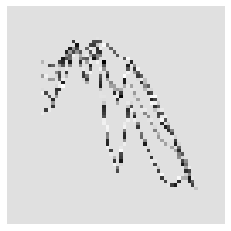

In [27]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [28]:
X = X/255

In [29]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [30]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [31]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [33]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 1 0 ... 1 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 0.9993346640053227, 1: 1.0003330003330004, 2: 1.0003330003330004}
Epoch 1/200
 1/24 [>.............................] - ETA: 0s - loss: 0.4344 - accuracy: 0.3828 - mse: 5.9626 - weighted_accuracy: 0.3829 - weighted_mse: 5.9625WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
24/24 [==============================] - 1s 27ms/step - loss: 0.2391 - accuracy: 0.3432 - mse: 1.7057 - weighted_accuracy: 0.3432 - weighted_mse: 1.7057 - val_loss: 0.1990 - val_accuracy: 0.3657 - val_mse: 0.9171 - val_weighted_accuracy: 0.3657 - val_weighted_mse: 0.9171
Epoch 2/200
24/24 [==============================] - 0s 10ms/step - loss: 0.2041 - accuracy: 0.3359 - mse: 1.1991 - weighted_accuracy: 0.3359 - weighted_mse: 1.1991 - val_loss: 0.1975 - val_accuracy: 0.3471 - 

Epoch 27/200
24/24 [==============================] - 0s 10ms/step - loss: 0.1800 - accuracy: 0.5113 - mse: 1.3159 - weighted_accuracy: 0.5113 - weighted_mse: 1.3159 - val_loss: 0.1707 - val_accuracy: 0.5545 - val_mse: 1.1253 - val_weighted_accuracy: 0.5545 - val_weighted_mse: 1.1253
Epoch 28/200
24/24 [==============================] - 0s 10ms/step - loss: 0.1790 - accuracy: 0.5103 - mse: 1.3442 - weighted_accuracy: 0.5103 - weighted_mse: 1.3442 - val_loss: 0.1718 - val_accuracy: 0.5532 - val_mse: 1.1123 - val_weighted_accuracy: 0.5532 - val_weighted_mse: 1.1123
Epoch 29/200
24/24 [==============================] - 0s 10ms/step - loss: 0.1787 - accuracy: 0.5103 - mse: 1.3373 - weighted_accuracy: 0.5103 - weighted_mse: 1.3373 - val_loss: 0.1708 - val_accuracy: 0.5598 - val_mse: 1.1013 - val_weighted_accuracy: 0.5598 - val_weighted_mse: 1.1013
Epoch 30/200
24/24 [==============================] - 0s 10ms/step - loss: 0.1787 - accuracy: 0.5196 - mse: 1.3116 - weighted_accuracy: 0.5196 - 

Epoch 56/200
24/24 [==============================] - 0s 10ms/step - loss: 0.1653 - accuracy: 0.5739 - mse: 1.4449 - weighted_accuracy: 0.5738 - weighted_mse: 1.4449 - val_loss: 0.1647 - val_accuracy: 0.5824 - val_mse: 1.2692 - val_weighted_accuracy: 0.5824 - val_weighted_mse: 1.2692
Epoch 57/200
24/24 [==============================] - 0s 10ms/step - loss: 0.1618 - accuracy: 0.5949 - mse: 1.4870 - weighted_accuracy: 0.5948 - weighted_mse: 1.4870 - val_loss: 0.1657 - val_accuracy: 0.5745 - val_mse: 1.3717 - val_weighted_accuracy: 0.5745 - val_weighted_mse: 1.3717
Epoch 58/200
24/24 [==============================] - 0s 10ms/step - loss: 0.1630 - accuracy: 0.5932 - mse: 1.4833 - weighted_accuracy: 0.5931 - weighted_mse: 1.4833 - val_loss: 0.1637 - val_accuracy: 0.5745 - val_mse: 1.3850 - val_weighted_accuracy: 0.5745 - val_weighted_mse: 1.3850
Epoch 59/200
24/24 [==============================] - 0s 10ms/step - loss: 0.1626 - accuracy: 0.5856 - mse: 1.4600 - weighted_accuracy: 0.5855 - 

Epoch 85/200
24/24 [==============================] - 0s 10ms/step - loss: 0.1482 - accuracy: 0.6528 - mse: 1.6151 - weighted_accuracy: 0.6527 - weighted_mse: 1.6151 - val_loss: 0.1640 - val_accuracy: 0.5771 - val_mse: 1.4153 - val_weighted_accuracy: 0.5771 - val_weighted_mse: 1.4153
Epoch 86/200
24/24 [==============================] - 0s 9ms/step - loss: 0.1481 - accuracy: 0.6588 - mse: 1.6074 - weighted_accuracy: 0.6587 - weighted_mse: 1.6073 - val_loss: 0.1642 - val_accuracy: 0.5718 - val_mse: 1.4652 - val_weighted_accuracy: 0.5718 - val_weighted_mse: 1.4652
Epoch 87/200
24/24 [==============================] - 0s 9ms/step - loss: 0.1468 - accuracy: 0.6558 - mse: 1.5904 - weighted_accuracy: 0.6557 - weighted_mse: 1.5904 - val_loss: 0.1648 - val_accuracy: 0.5638 - val_mse: 1.5369 - val_weighted_accuracy: 0.5638 - val_weighted_mse: 1.5369
Epoch 88/200
24/24 [==============================] - 0s 9ms/step - loss: 0.1475 - accuracy: 0.6631 - mse: 1.5799 - weighted_accuracy: 0.6631 - wei

Epoch 114/200
24/24 [==============================] - 0s 9ms/step - loss: 0.1319 - accuracy: 0.7057 - mse: 1.8068 - weighted_accuracy: 0.7057 - weighted_mse: 1.8068 - val_loss: 0.1714 - val_accuracy: 0.5399 - val_mse: 1.7864 - val_weighted_accuracy: 0.5399 - val_weighted_mse: 1.7864
Epoch 115/200
24/24 [==============================] - 0s 9ms/step - loss: 0.1294 - accuracy: 0.7194 - mse: 1.8411 - weighted_accuracy: 0.7193 - weighted_mse: 1.8410 - val_loss: 0.1715 - val_accuracy: 0.5452 - val_mse: 1.8305 - val_weighted_accuracy: 0.5452 - val_weighted_mse: 1.8305
Epoch 116/200
24/24 [==============================] - 0s 10ms/step - loss: 0.1302 - accuracy: 0.7170 - mse: 1.8485 - weighted_accuracy: 0.7170 - weighted_mse: 1.8484 - val_loss: 0.1730 - val_accuracy: 0.5492 - val_mse: 1.9162 - val_weighted_accuracy: 0.5492 - val_weighted_mse: 1.9162
Epoch 117/200
24/24 [==============================] - 0s 9ms/step - loss: 0.1305 - accuracy: 0.7064 - mse: 1.8775 - weighted_accuracy: 0.7063 -

Epoch 143/200
24/24 [==============================] - 0s 9ms/step - loss: 0.1109 - accuracy: 0.7806 - mse: 2.2520 - weighted_accuracy: 0.7806 - weighted_mse: 2.2519 - val_loss: 0.1831 - val_accuracy: 0.5452 - val_mse: 2.1870 - val_weighted_accuracy: 0.5452 - val_weighted_mse: 2.1870
Epoch 144/200
24/24 [==============================] - 0s 9ms/step - loss: 0.1119 - accuracy: 0.7636 - mse: 2.2678 - weighted_accuracy: 0.7636 - weighted_mse: 2.2677 - val_loss: 0.1842 - val_accuracy: 0.5386 - val_mse: 2.1610 - val_weighted_accuracy: 0.5386 - val_weighted_mse: 2.1610
Epoch 145/200
24/24 [==============================] - 0s 9ms/step - loss: 0.1118 - accuracy: 0.7723 - mse: 2.2692 - weighted_accuracy: 0.7723 - weighted_mse: 2.2690 - val_loss: 0.1883 - val_accuracy: 0.5332 - val_mse: 2.3363 - val_weighted_accuracy: 0.5332 - val_weighted_mse: 2.3363
Epoch 146/200
24/24 [==============================] - 0s 9ms/step - loss: 0.1108 - accuracy: 0.7813 - mse: 2.2780 - weighted_accuracy: 0.7812 - 

Epoch 172/200
24/24 [==============================] - 0s 11ms/step - loss: 0.0897 - accuracy: 0.8222 - mse: 2.9017 - weighted_accuracy: 0.8222 - weighted_mse: 2.9015 - val_loss: 0.2075 - val_accuracy: 0.5439 - val_mse: 2.8387 - val_weighted_accuracy: 0.5439 - val_weighted_mse: 2.8387
Epoch 173/200
24/24 [==============================] - 0s 10ms/step - loss: 0.0922 - accuracy: 0.8216 - mse: 2.8446 - weighted_accuracy: 0.8215 - weighted_mse: 2.8444 - val_loss: 0.2107 - val_accuracy: 0.5439 - val_mse: 2.8490 - val_weighted_accuracy: 0.5439 - val_weighted_mse: 2.8490
Epoch 174/200
24/24 [==============================] - 0s 10ms/step - loss: 0.0917 - accuracy: 0.8212 - mse: 2.8865 - weighted_accuracy: 0.8212 - weighted_mse: 2.8863 - val_loss: 0.2089 - val_accuracy: 0.5359 - val_mse: 2.7910 - val_weighted_accuracy: 0.5359 - val_weighted_mse: 2.7910
Epoch 175/200
24/24 [==============================] - 0s 10ms/step - loss: 0.0916 - accuracy: 0.8286 - mse: 2.8516 - weighted_accuracy: 0.828

In [34]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.24915280938148499
Test accuracy: 0.5531914830207825


In [35]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.26357982 -2.396244   -0.44586062]
 [ 0.34244972 -2.7074673  -0.8525573 ]
 [-2.235291    0.17577034 -0.8230371 ]
 ...
 [-0.6164947  -2.324078   -0.22465196]
 [-3.6435      0.98338675 -1.4835745 ]
 [ 0.84557587 -3.8995888  -1.1951627 ]]


Counter({0: 270, 1: 259, 2: 223})

In [36]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({0: 250, 2: 251, 1: 251})

In [37]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 752
actual predicted buys: 175
actual buys but predicted sell: 17
actual buys but predicted hold: 59
actual sells but predicted buy: 21
actual predicted sells: 153
actual sells but predicted hold: 76
actual holds but predicted buy: 63
actual holds but predicted sell: 100
actual predicted holds: 88
Percentage buys correct: 69.7211155378486%
Percentage sells correct: 61.2%
Percentage holds correct: 35.059760956175296%
actual buys: 251
actual sells: 250
actual holds: 251


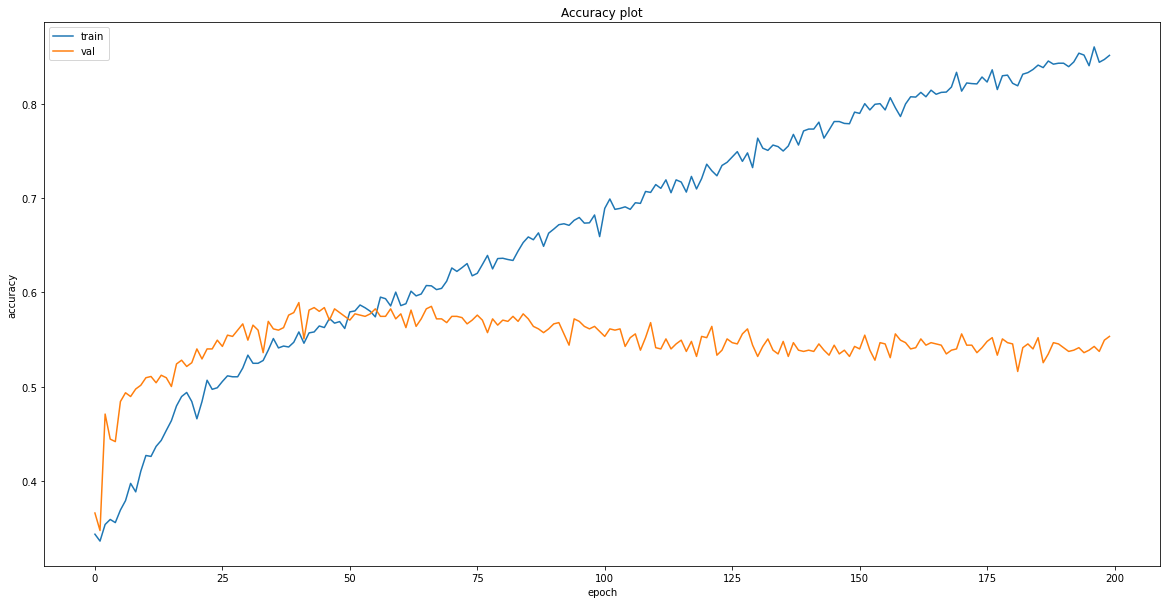

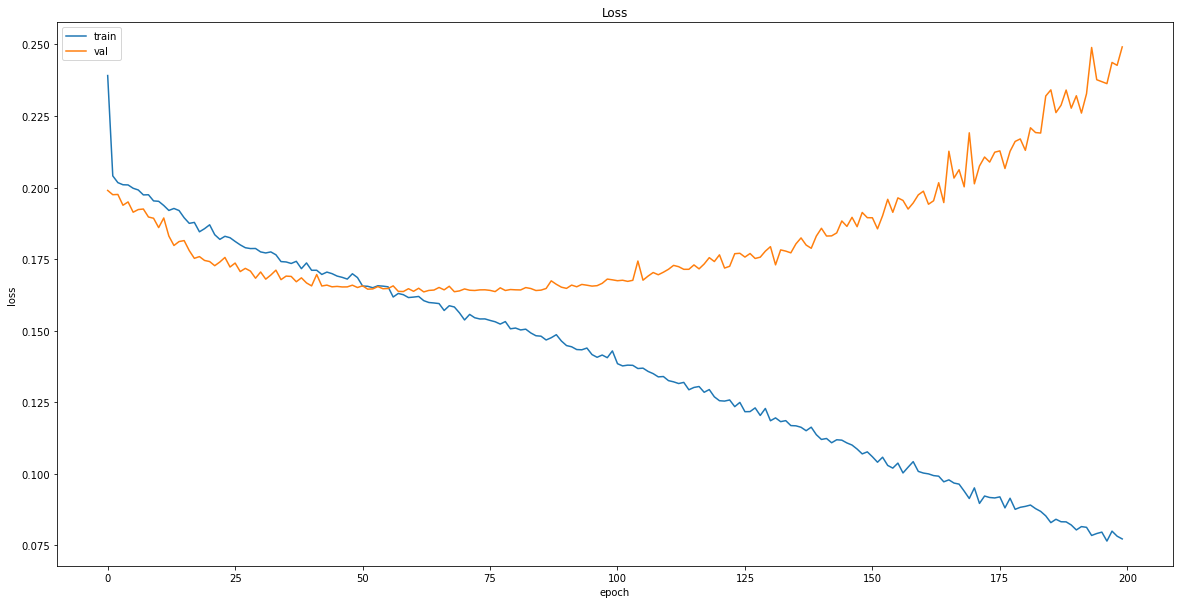

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [314]:
# Save model
model.save("models/{}".format('balanced_image_cnn_buy_hold_sell_noncyclic.model'))

INFO:tensorflow:Assets written to: models/balanced_image_cnn_buy_hold_sell_noncyclic.model\assets


### Kweichow Moutai Co., Ltd.

### Test Performance

### non-recession

In [315]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


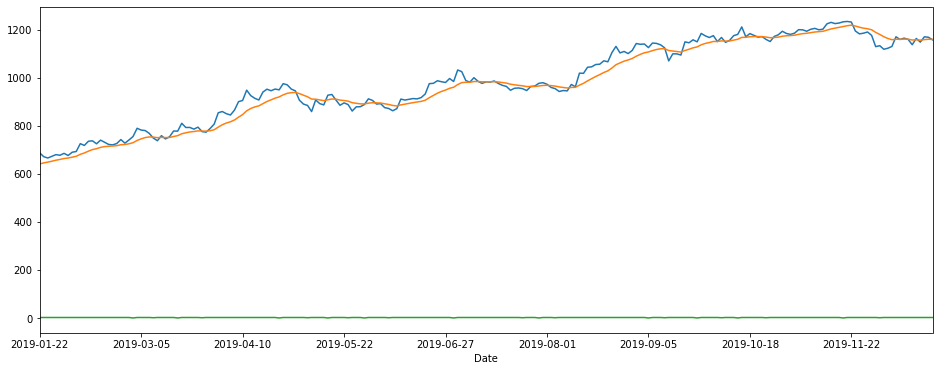

In [316]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [317]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [318]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [319]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [320]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [321]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [322]:
model = tf.keras.models.load_model("models/balanced_image_cnn_buy_hold_sell_noncyclic.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 5ms/step - loss: 0.2870 - accuracy: 0.4300 - mean_squared_error: 3.5288 - weighted_accuracy: 0.4300 - weighted_mean_squared_error: 3.5288
Test loss: 0.28695183992385864
Test accuracy: 0.4299516975879669


In [323]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 74, 1: 57, 0: 76})

In [324]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [325]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)

In [326]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,740.00000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.76001,709.868261,-6.049880,47694490.0,2.0,2,2
2019-02-20,722.00000,713.082376,-17.677836,44744340.0,2.0,2,2
2019-02-21,720.25000,714.454318,-29.824573,40956103.0,2.0,2,2
2019-02-22,726.01001,715.345962,-32.098776,37971063.0,2.0,2,2


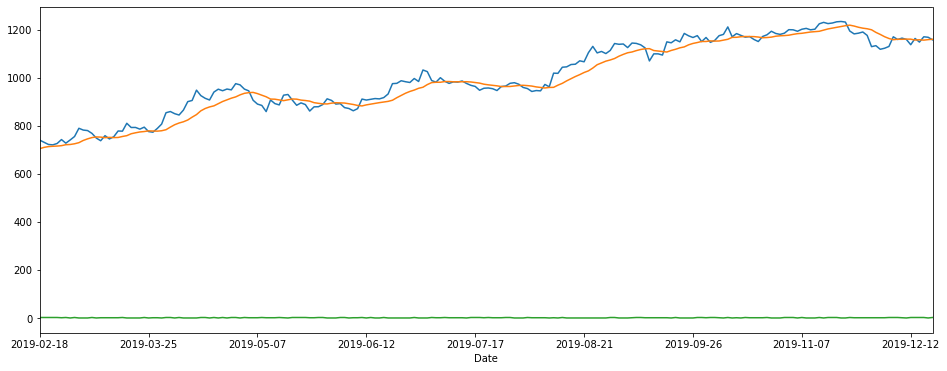

In [327]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

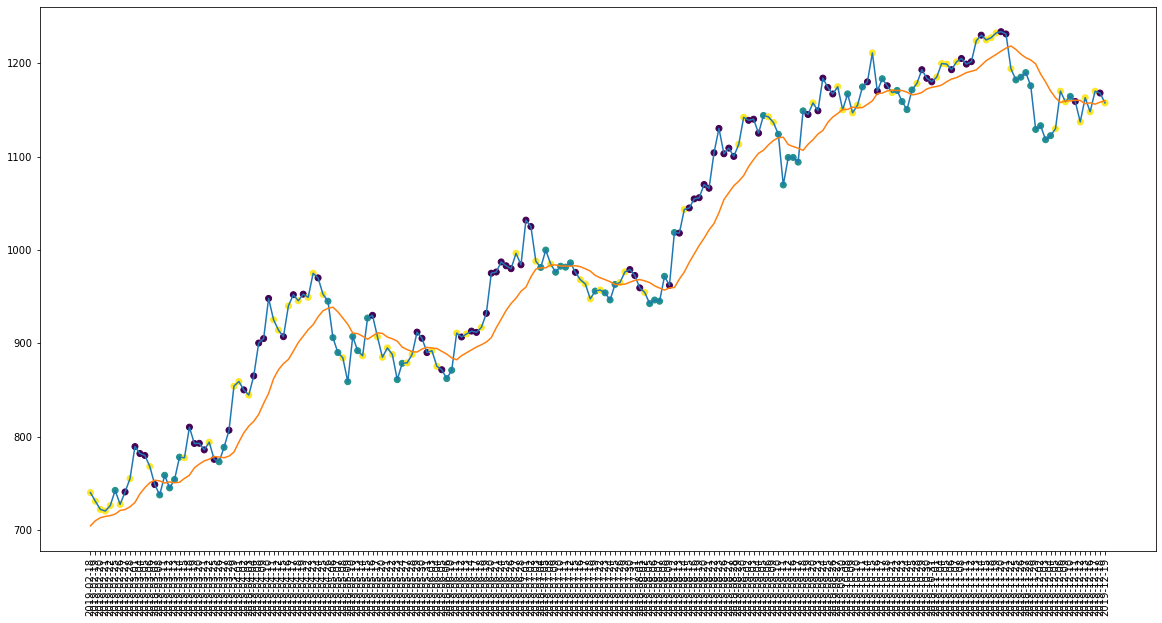

In [328]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

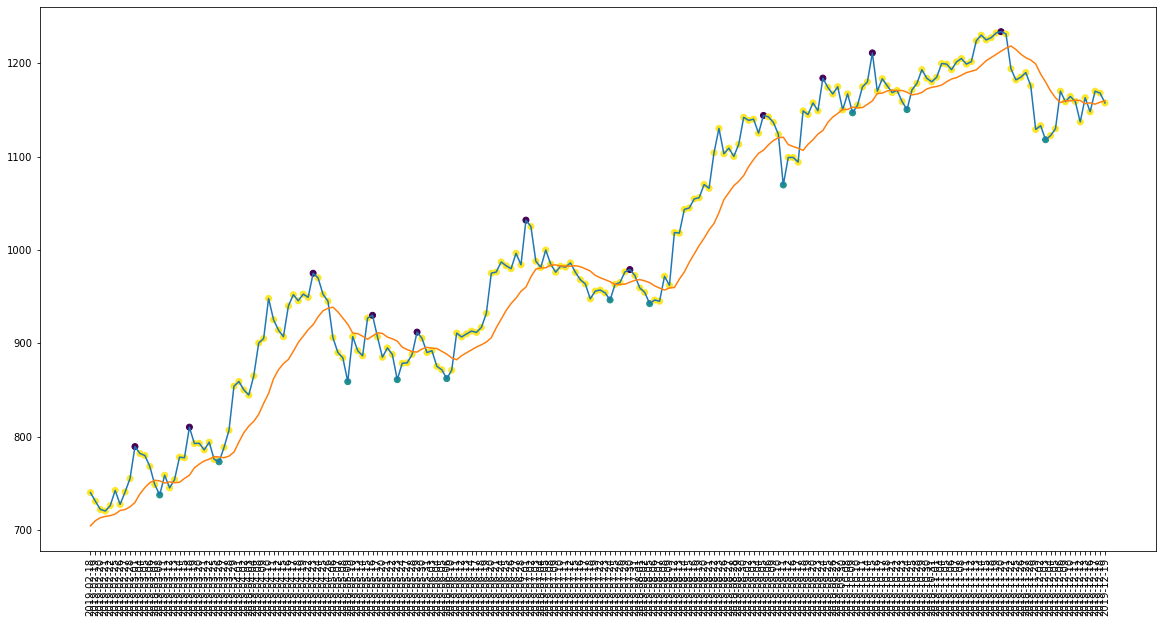

In [329]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [330]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 46
actual holds but predicted sell: 68
actual predicted holds: 71
Percentage buys correct: 90.9090909090909%
Percentage sells correct: 72.72727272727273%
Percentage holds correct: 38.37837837837838%
actual buys: 11
actual sells: 11
actual holds: 185


In [331]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 52.63157894736842%
Percentage sells correct: 44.73684210526316%
Percentage holds correct: 90.41095890410959%


In [332]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $742.3300170898438
Shares owned at the moment: 13
Cash capital at the moment: $323.1714797210698


Price increase from previously bought: 6.035772152060703%
Share price: $789.2999877929688
Shares owned at the moment: 0
Cash capital at the moment: $10555.853846466065


Share price: $737.5
Shares owned at the moment: 14
Cash capital at the moment: $202.460096466064


Price increase from previously bought: 9.54147644560086%
Share price: $810.0900268554688
Shares owned at the moment: 0
Cash capital at the moment: $11512.53200640869


Share price: $773.0
Shares owned at the moment: 14
Cash capital at the moment: $660.7715064086897


Price increase from previously bought: 9.65962619613656%
Share price: $850.0
Shares owned at the moment: 0
Cash capital at the moment: $12528.04650640869


Share price: $945.0
Shares owned at the moment: 13
Cash capital at the moment: $209.2627564086888


Stop Loss Activated!

Share price: $906.0
Shares owned at the moment: 0
Cash capital at the mom

In [333]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


### Recession

In [334]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


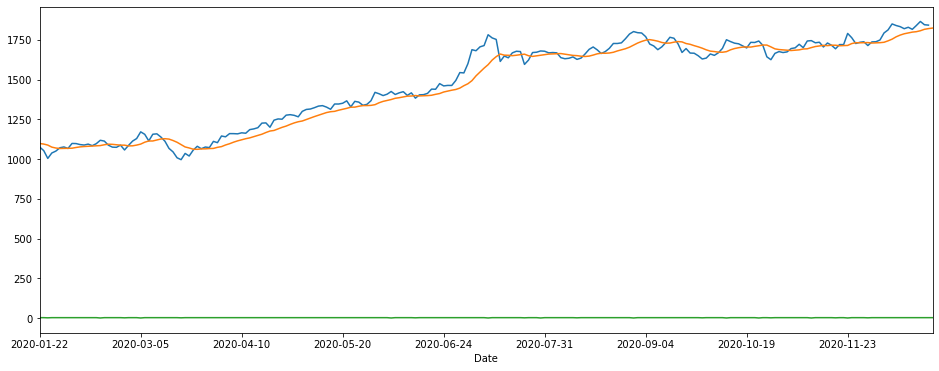

In [335]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [336]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [337]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [338]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [339]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [340]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [341]:
model = tf.keras.models.load_model("models/balanced_image_cnn_buy_hold_sell_noncyclic.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 5ms/step - loss: 0.3443 - accuracy: 0.3654 - mean_squared_error: 3.7718 - weighted_accuracy: 0.3654 - weighted_mean_squared_error: 3.7718
Test loss: 0.3443238139152527
Test accuracy: 0.36538460850715637


In [342]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 48, 0: 90, 2: 70})

In [343]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [344]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)

In [345]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,1,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,0,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,0,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,0,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


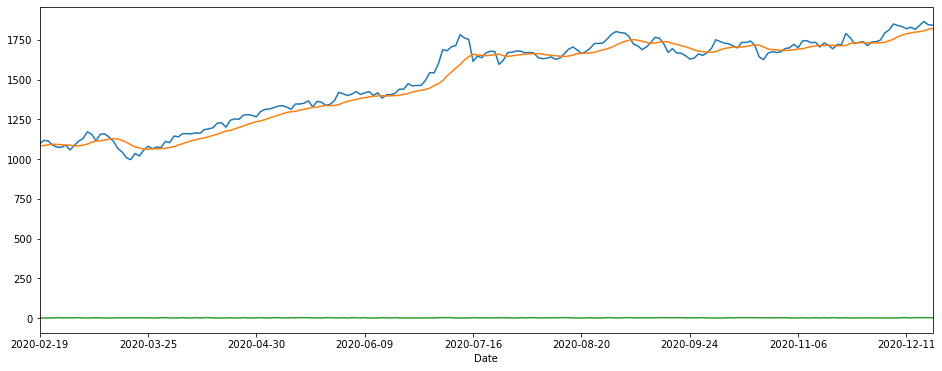

In [346]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

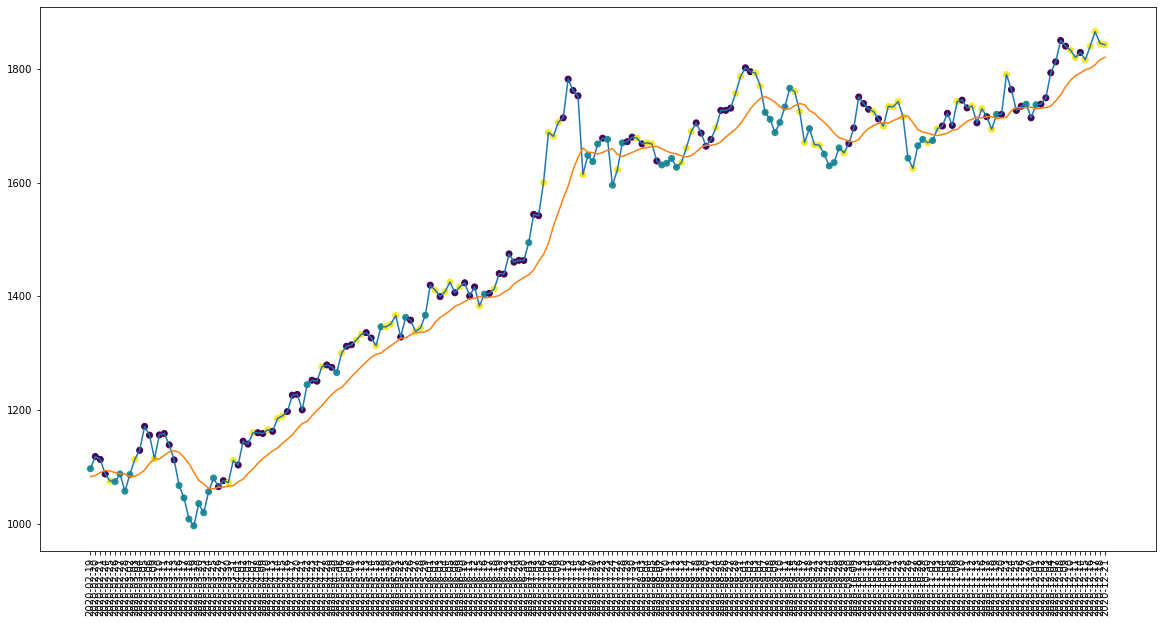

In [347]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

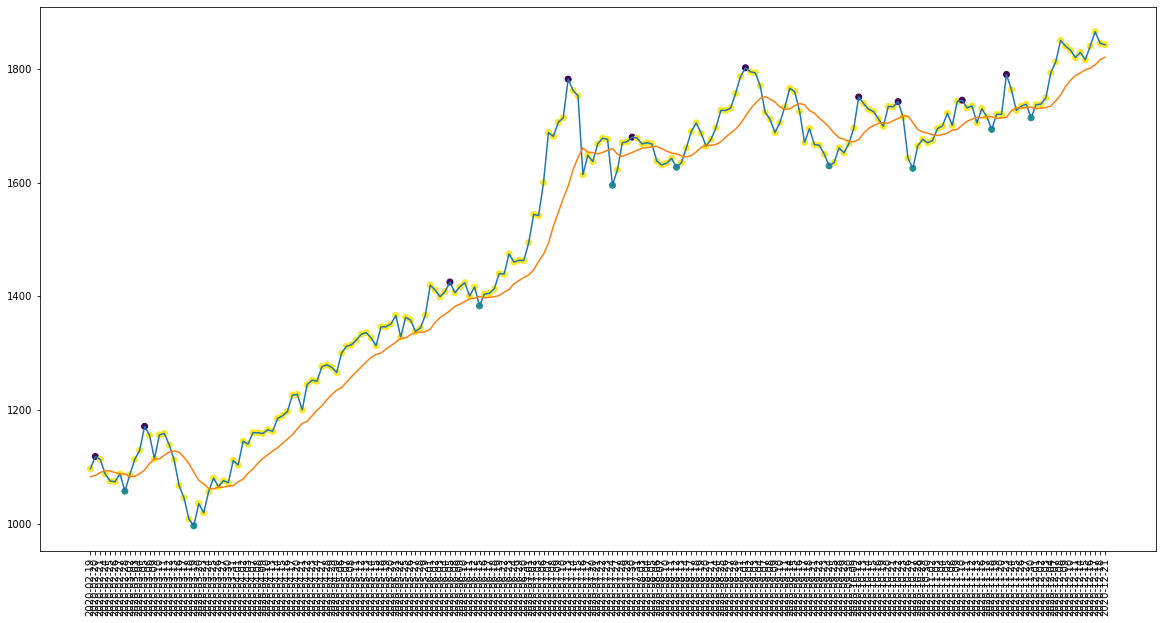

In [348]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [349]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 43
actual holds but predicted sell: 82
actual predicted holds: 64
Percentage buys correct: 55.55555555555556%
Percentage sells correct: 70.0%
Percentage holds correct: 33.86243386243386%
actual buys: 9
actual sells: 10
actual holds: 189


In [350]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 56.25%
Percentage sells correct: 44.44444444444444%
Percentage holds correct: 82.6086956521739%


In [351]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1096.5
Shares owned at the moment: 9
Cash capital at the moment: $104.36162499999955


Stop Loss Activated!

Share price: $1057.0
Shares owned at the moment: 0
Cash capital at the moment: $9591.200874999999


Share price: $1057.0
Shares owned at the moment: 9
Cash capital at the moment: $52.040124999997715


Price increase from previously bought: 6.511260914727868%
Share price: $1128.9200439453125
Shares owned at the moment: 0
Cash capital at the moment: $10184.379749420163


Share price: $1067.0
Shares owned at the moment: 9
Cash capital at the moment: $554.9714994201622


Stop Loss Activated!

Share price: $1007.989990234375
Shares owned at the moment: 0
Cash capital at the moment: $9601.933659271237


Share price: $1007.989990234375
Shares owned at the moment: 9
Cash capital at the moment: $505.0759949035619


Price increase from previously bought: 5.3581439781053675%
Share price: $1064.9200439453123
Shares owned at the moment: 0
Cash capital at the moment: $10062.9996

In [352]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


### Midea Group

### Test Performance

#### Non-Recession

In [353]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


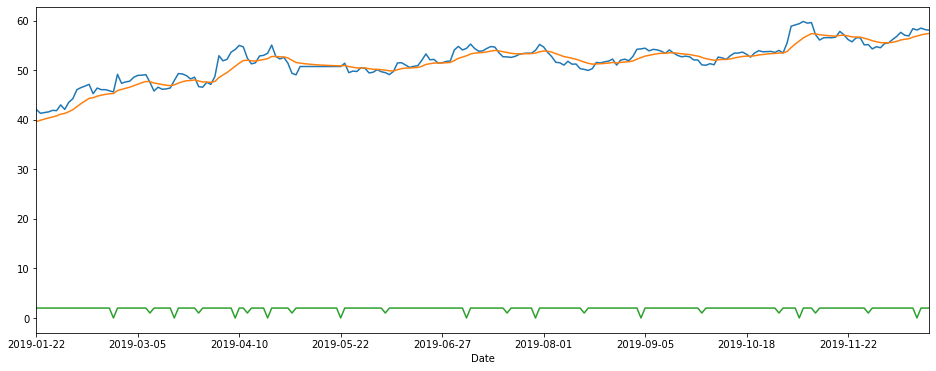

In [354]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [355]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [356]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [357]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [358]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [359]:
model = tf.keras.models.load_model("models/balanced_image_cnn_buy_hold_sell_noncyclic.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 5ms/step - loss: 0.3433 - accuracy: 0.3913 - mean_squared_error: 3.8917 - weighted_accuracy: 0.3913 - weighted_mean_squared_error: 3.8917
Test loss: 0.34330230951309204
Test accuracy: 0.3913043439388275


In [360]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 70, 0: 72, 1: 65})

In [361]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [362]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)

In [363]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,2,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,2,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,2,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,0,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,2,2


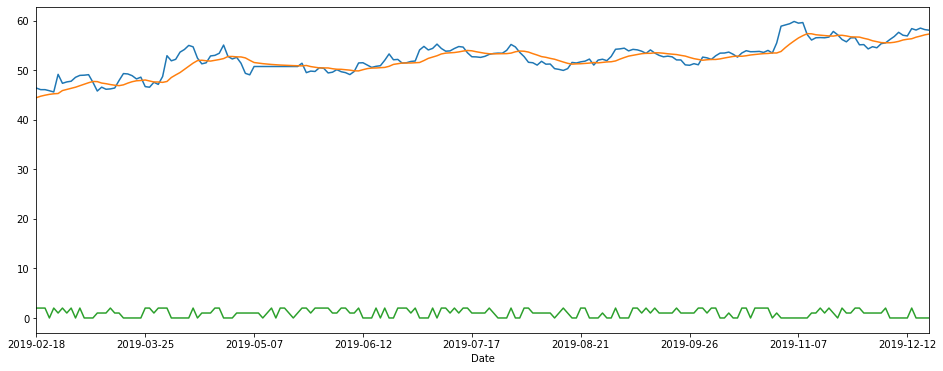

In [364]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

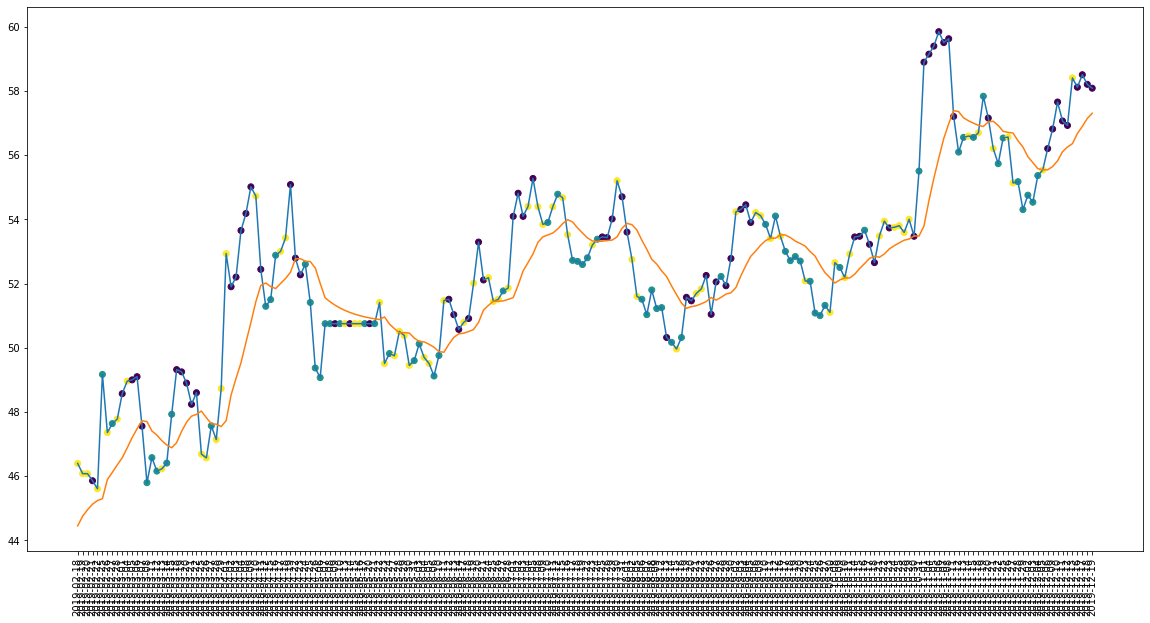

In [365]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

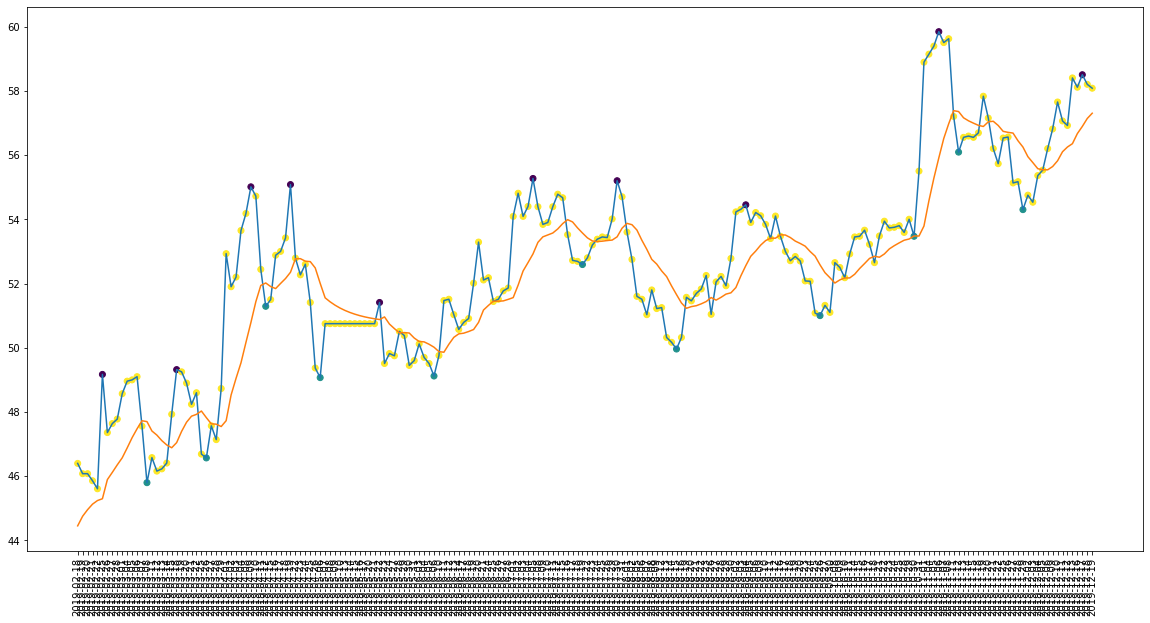

In [366]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [367]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 56
actual holds but predicted sell: 64
actual predicted holds: 66
Percentage buys correct: 72.72727272727273%
Percentage sells correct: 70.0%
Percentage holds correct: 35.483870967741936%
actual buys: 11
actual sells: 10
actual holds: 186


In [368]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 61.53846153846154%
Percentage sells correct: 54.929577464788736%
Percentage holds correct: 81.42857142857143%


In [369]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $49.16999816894531
Shares owned at the moment: 202
Cash capital at the moment: $40.346435890198336


Stop Loss Activated!

Share price: $47.36000061035156
Shares owned at the moment: 0
Cash capital at the moment: $9580.758078842164


Share price: $47.63999938964844
Shares owned at the moment: 200
Cash capital at the moment: $26.5562012481696


Stop Loss Activated!

Share price: $45.79999923706055
Shares owned at the moment: 0
Cash capital at the moment: $9161.366049079896


Share price: $45.79999923706055
Shares owned at the moment: 199
Cash capital at the moment: $22.1021513223659


Price increase from previously bought: 7.390267411779328%
Share price: $49.31999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9809.791720759393


Share price: $47.56999969482422
Shares owned at the moment: 205
Cash capital at the moment: $31.12419599247005


Price increase from previously bought: 8.803170635037727%
Share price: $51.9000015258789
Shares owned at the momen

In [370]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


### Recession

In [371]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


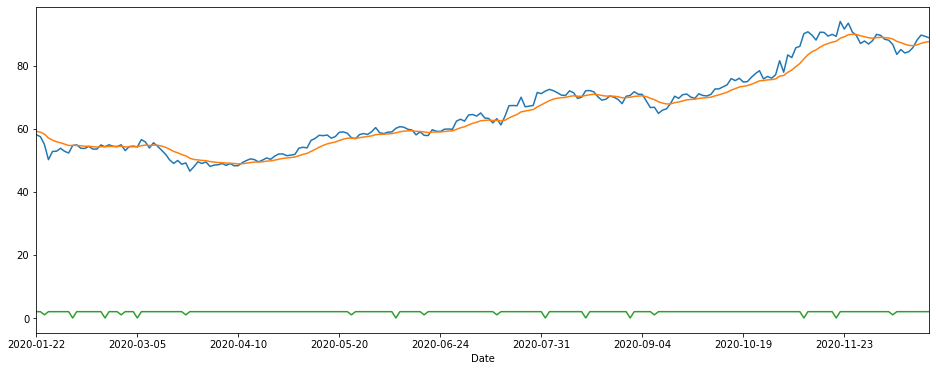

In [372]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [373]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [374]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [375]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [376]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [377]:
model = tf.keras.models.load_model("models/balanced_image_cnn_buy_hold_sell_noncyclic.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.4212 - accuracy: 0.2452 - mean_squared_error: 4.3379 - weighted_accuracy: 0.2452 - weighted_mean_squared_error: 4.3379
Test loss: 0.42123153805732727
Test accuracy: 0.24519230425357819


In [378]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 47, 0: 96, 1: 65})

In [379]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [380]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)

In [381]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,2,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,0,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,0,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,2,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,0,2


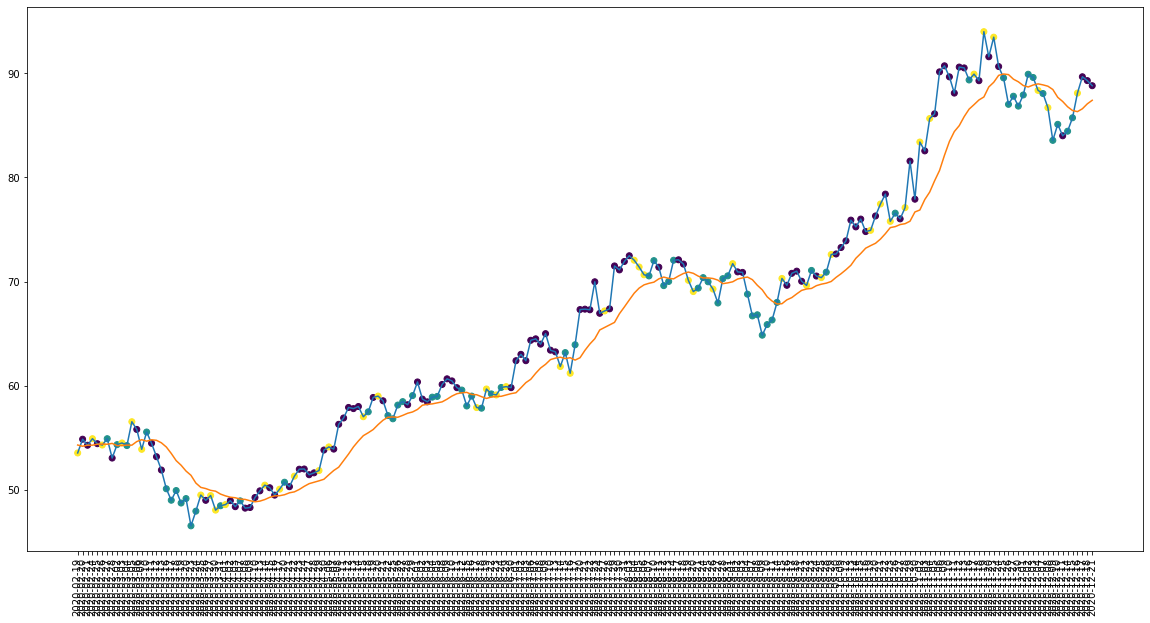

In [382]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

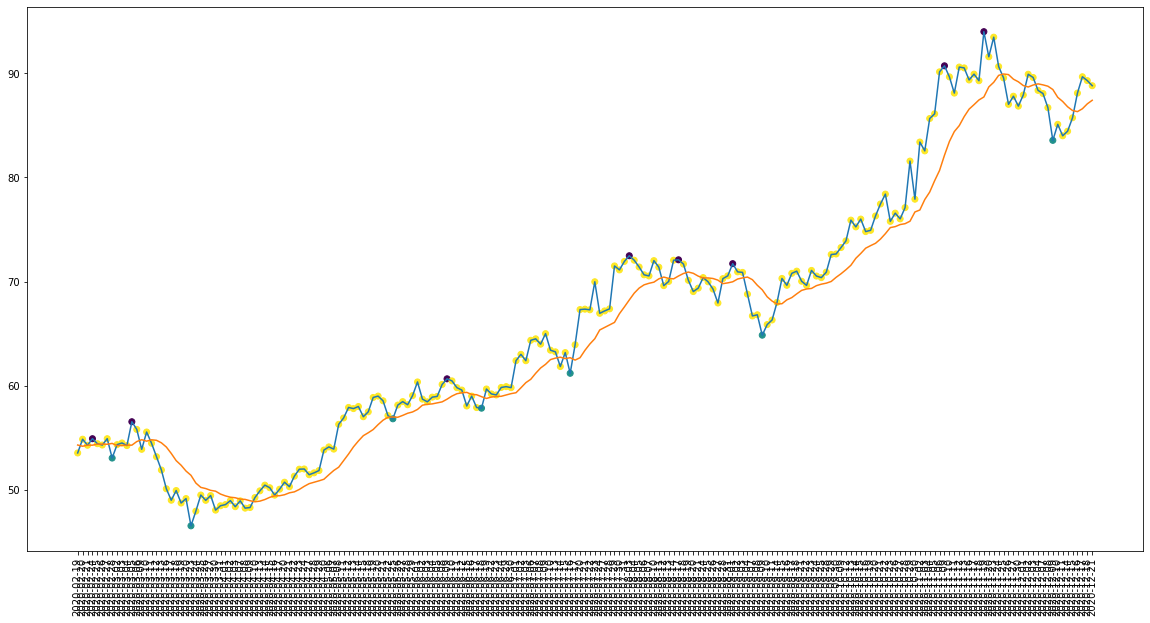

In [383]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [384]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 60
actual holds but predicted sell: 91
actual predicted holds: 42
Percentage buys correct: 71.42857142857143%
Percentage sells correct: 50.0%
Percentage holds correct: 21.761658031088082%
actual buys: 7
actual sells: 8
actual holds: 193


In [385]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 57.8125%
Percentage sells correct: 55.208333333333336%
Percentage holds correct: 82.97872340425532%


In [386]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.90999984741211
Shares owned at the moment: 181
Cash capital at the moment: $33.95857519435776


Stop Loss Activated!

Share price: $53.04999923706055
Shares owned at the moment: 0
Cash capital at the moment: $9609.602799982069


Share price: $54.34000015258789
Shares owned at the moment: 176
Cash capital at the moment: $19.462213052747757


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9128.742880868907


Share price: $50.099998474121094
Shares owned at the moment: 181
Cash capital at the moment: $35.705882812495474


Stop Loss Activated!

Share price: $48.72999954223633
Shares owned at the moment: 0
Cash capital at the moment: $8831.580442685123


Share price: $48.72999954223633
Shares owned at the moment: 180
Cash capital at the moment: $36.05917530917577


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $8390.222039650911


Share price: 

In [387]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


## Walmart

### Test Performance

### non-recession

In [388]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


In [389]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [390]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [391]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [392]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [393]:
model = tf.keras.models.load_model("models/balanced_image_cnn_buy_hold_sell_noncyclic.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 5ms/step - loss: 0.3560 - accuracy: 0.3073 - mean_squared_error: 3.8378 - weighted_accuracy: 0.3073 - weighted_mean_squared_error: 3.8378
Test loss: 0.35599285364151
Test accuracy: 0.30733945965766907


In [394]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 63, 0: 88, 1: 67})

In [395]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [396]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/wmt_data_test.csv")
df.set_index('Date', inplace=True)

In [397]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,0,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,0,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,0,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,2,2


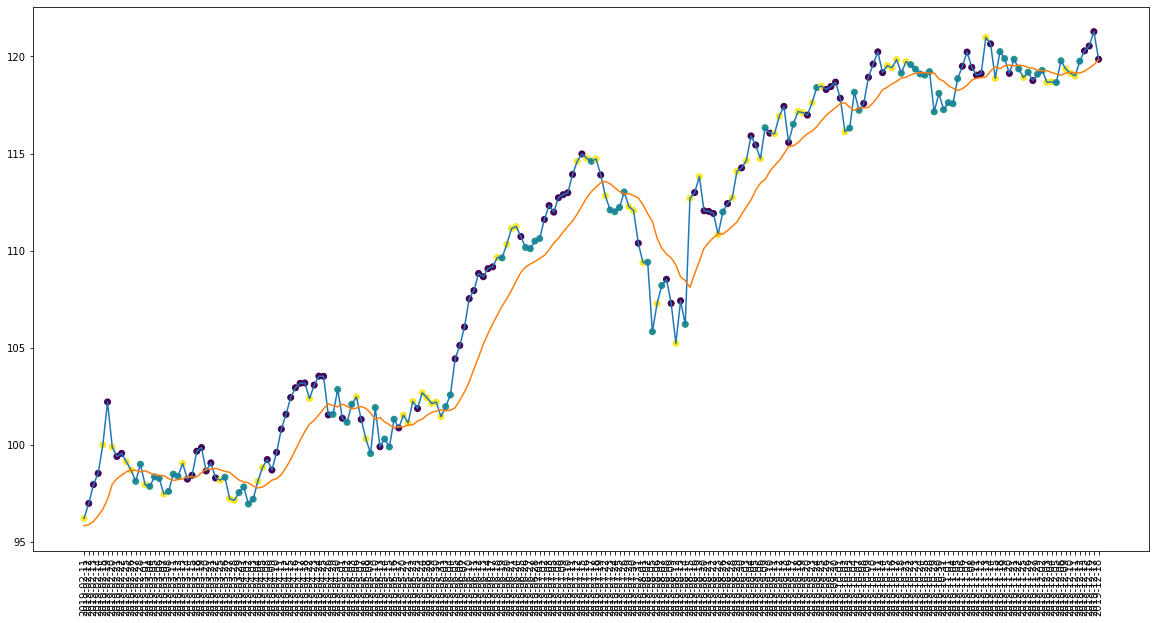

In [398]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

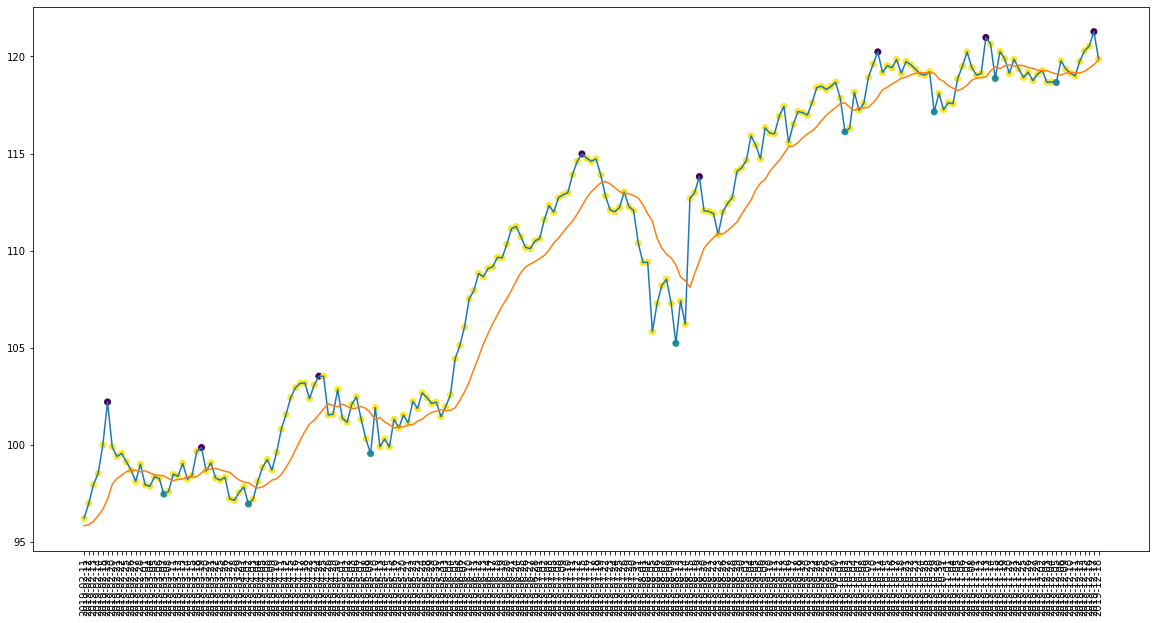

In [399]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [400]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 63
actual holds but predicted sell: 82
actual predicted holds: 57
Percentage buys correct: 50.0%
Percentage sells correct: 75.0%
Percentage holds correct: 28.217821782178216%
actual buys: 8
actual sells: 8
actual holds: 202


In [401]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 49.25373134328358%
Percentage sells correct: 39.08045977011494%
Percentage holds correct: 82.53968253968254%


In [402]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.11000061035156
Shares owned at the moment: 101
Cash capital at the moment: $63.63988568496643


Price increase from previously bought: 5.235013188024018%
Share price: $103.52999877929688
Shares owned at the moment: 0
Cash capital at the moment: $10491.414305233


Share price: $101.55999755859376
Shares owned at the moment: 103
Cash capital at the moment: $1.9676873893695301


Price increase from previously bought: 5.578111579278855%
Share price: $107.5199966430664
Shares owned at the moment: 0
Cash capital at the moment: $11046.07230257606


Share price: $109.62000274658205
Shares owned at the moment: 100
Cash capital at the moment: $53.92652716254452


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10606.825996728889


Share price: $105.81999969482422
Shares owned at the moment: 99
Cash capital at the moment: $101.83653202437563


Price increase from previously bought: 6.482827289801785%
Share price: $

In [403]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


### recession

In [404]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


In [405]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [406]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [407]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [408]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [409]:
model = tf.keras.models.load_model("models/balanced_image_cnn_buy_hold_sell_noncyclic.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.3468 - accuracy: 0.3516 - mean_squared_error: 3.8537 - weighted_accuracy: 0.3516 - weighted_mean_squared_error: 3.8537
Test loss: 0.3468363285064697
Test accuracy: 0.35159817337989807


In [410]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 69, 2: 74, 0: 76})

In [411]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [412]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)

In [413]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,1,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,0,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,0,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,0,0


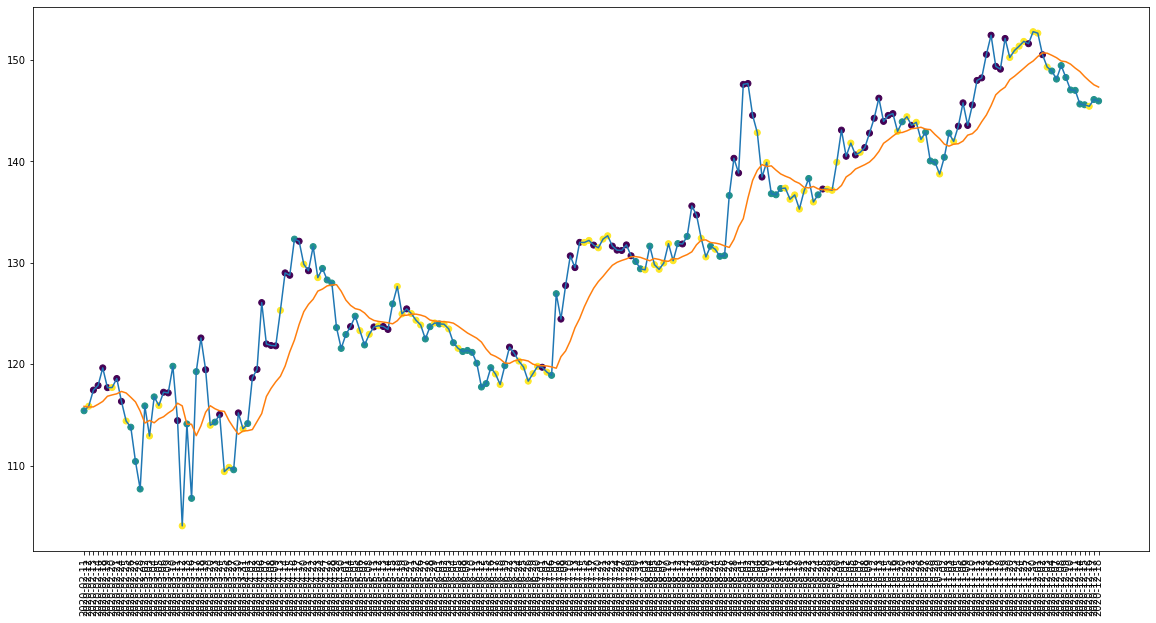

In [414]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

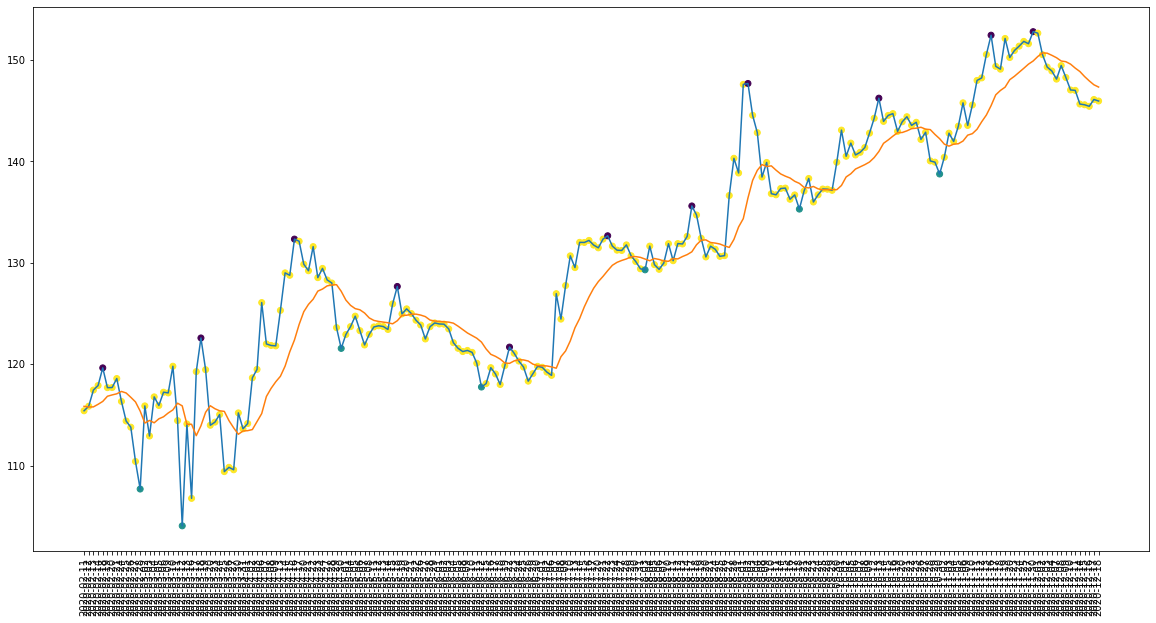

In [415]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [416]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 65
actual holds but predicted sell: 69
actual predicted holds: 67
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 63.63636363636363%
Percentage holds correct: 33.333333333333336%
actual buys: 7
actual sells: 11
actual holds: 201


In [417]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 48.529411764705884%
Percentage sells correct: 48.68421052631579%
Percentage holds correct: 83.78378378378379%


In [418]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $115.4000015258789
Shares owned at the moment: 86
Cash capital at the moment: $48.30776841354418


Stop Loss Activated!

Share price: $110.4000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9516.59829927826


Share price: $110.4000015258789
Shares owned at the moment: 85
Cash capital at the moment: $106.79216922187697


Price increase from previously bought: 5.895383471408988%
Share price: $117.2300033569336
Shares owned at the moment: 0
Cash capital at the moment: $10043.939941276549


Share price: $119.79000091552734
Shares owned at the moment: 83
Cash capital at the moment: $74.02779757881035


Stop Loss Activated!

Share price: $114.43000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9545.599175338744


Share price: $114.0999984741211
Shares owned at the moment: 83
Cash capital at the moment: $49.25597733497489


Stop Loss Activated!

Share price: $106.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $

In [419]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


## Fresh Del Monte Produce Inc

### Test Performance

### non-recession

In [420]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    30.219999  29.918096 -32.033467  1515700.0     2.0
2019-01-23    30.480000  30.004543 -24.791121  1646600.0     2.0
2019-01-24    30.459999  30.074613 -28.980936  1528300.0     2.0
2019-01-25    30.639999  30.161596 -35.265743  1632300.0     2.0
2019-01-28    30.879999  30.272119 -23.671560  1731100.0     2.0


In [421]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [422]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [423]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
X = X/255
y = np.array(y)

In [424]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [425]:
model = tf.keras.models.load_model("models/balanced_image_cnn_buy_hold_sell_noncyclic.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.3172 - accuracy: 0.4128 - mean_squared_error: 3.8241 - weighted_accuracy: 0.4128 - weighted_mean_squared_error: 3.8241
Test loss: 0.31719303131103516
Test accuracy: 0.4128440320491791


In [426]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 85, 0: 68, 1: 65})

In [427]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 198, 0: 10, 1: 10})

In [428]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)

In [429]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,2,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,2,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,2,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,2,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,2,0


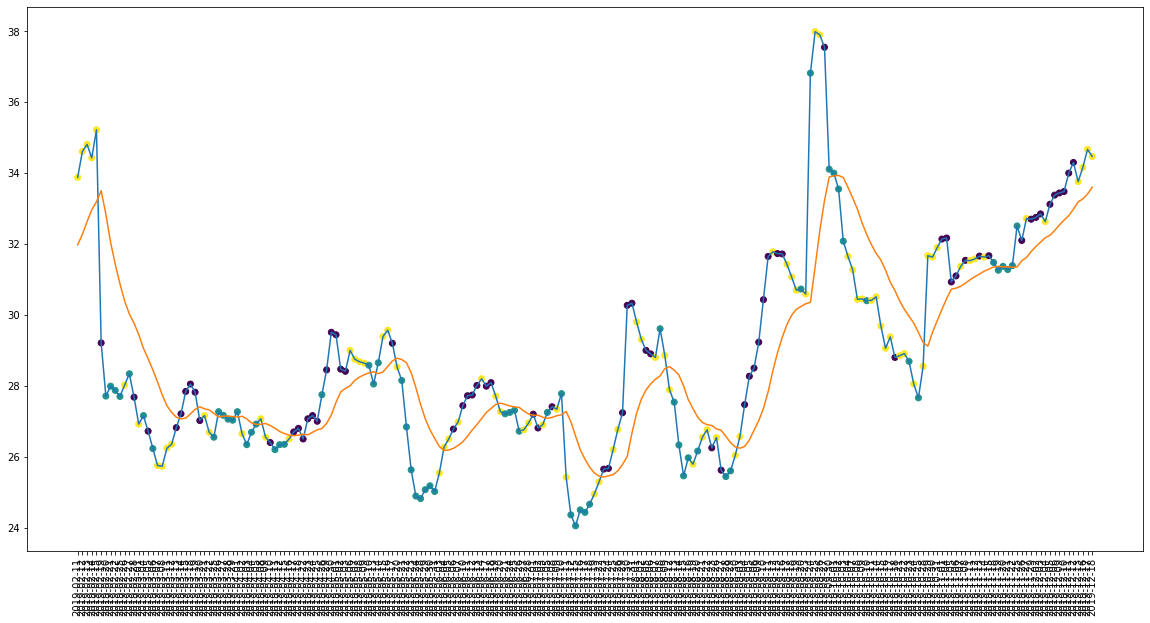

In [430]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

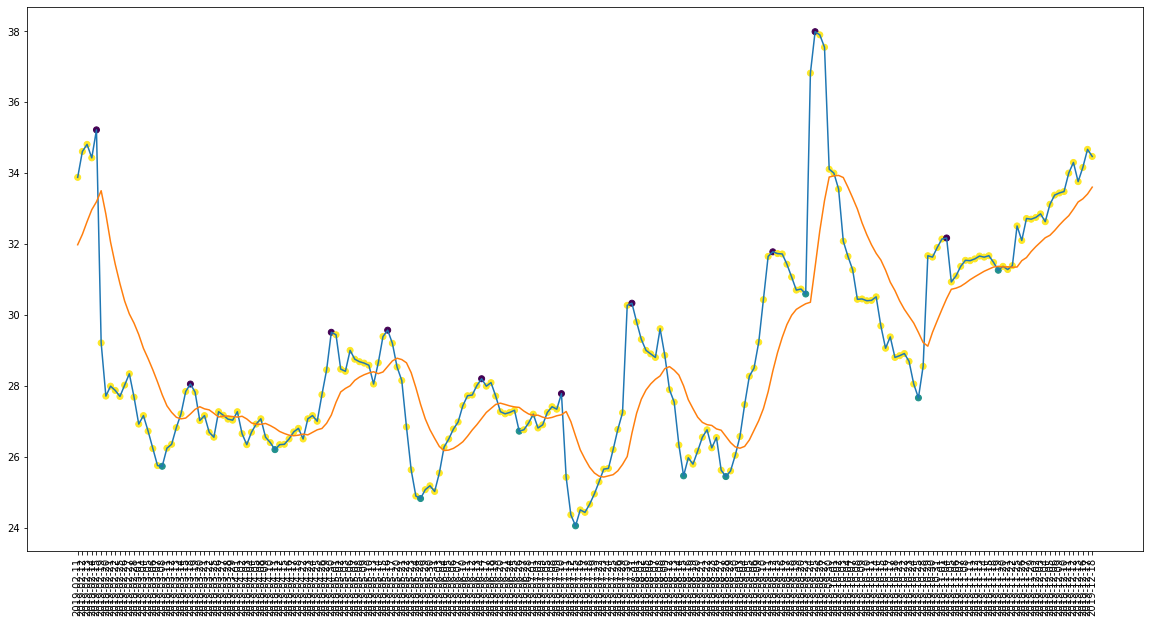

In [431]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [432]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 56
actual holds but predicted sell: 64
actual predicted holds: 78
Percentage buys correct: 80.0%
Percentage sells correct: 40.0%
Percentage holds correct: 39.39393939393939%
actual buys: 10
actual sells: 10
actual holds: 198


In [433]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 53.84615384615385%
Percentage sells correct: 47.05882352941177%
Percentage holds correct: 85.71428571428571%


In [434]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.709999084472656
Shares owned at the moment: 359
Cash capital at the moment: $24.753632078170995


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9662.456889392375


Share price: $27.15999984741211
Shares owned at the moment: 354
Cash capital at the moment: $21.376683557033175


Stop Loss Activated!

Share price: $26.229999542236328
Shares owned at the moment: 0
Cash capital at the moment: $9281.261616954325


Share price: $26.229999542236328
Shares owned at the moment: 352
Cash capital at the moment: $22.911138530253083


Price increase from previously bought: 5.846933279836342%
Share price: $27.84000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9795.642072093486


Share price: $26.54999923706055
Shares owned at the moment: 367
Cash capital at the moment: $24.996765362258884


Price increase from previously bought: 6.862443085572112%
Share price: $28.45000076293945
Shares owned at

In [435]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


### recession

In [436]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2020-01-22    34.250000  34.338683 -60.666656  -55800.0     2.0
2020-01-23    34.130001  34.306578 -67.360995 -191000.0     2.0
2020-01-24    34.520000  34.339413 -36.764689   18500.0     2.0
2020-01-27    32.290001  34.024118 -98.555924 -130500.0     2.0
2020-01-28    32.160000  33.737331 -85.885906 -280200.0     2.0


In [437]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [438]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [439]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [440]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [441]:
model = tf.keras.models.load_model("models/balanced_image_cnn_buy_hold_sell_noncyclic.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.3946 - accuracy: 0.3151 - mean_squared_error: 4.1608 - weighted_accuracy: 0.3151 - weighted_mean_squared_error: 4.1608
Test loss: 0.3945530354976654
Test accuracy: 0.31506848335266113


In [442]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 79, 2: 62, 1: 78})

In [443]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 199, 0: 10, 1: 10})

In [444]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)

In [445]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,0,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,0,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,0,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,0,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,0,2


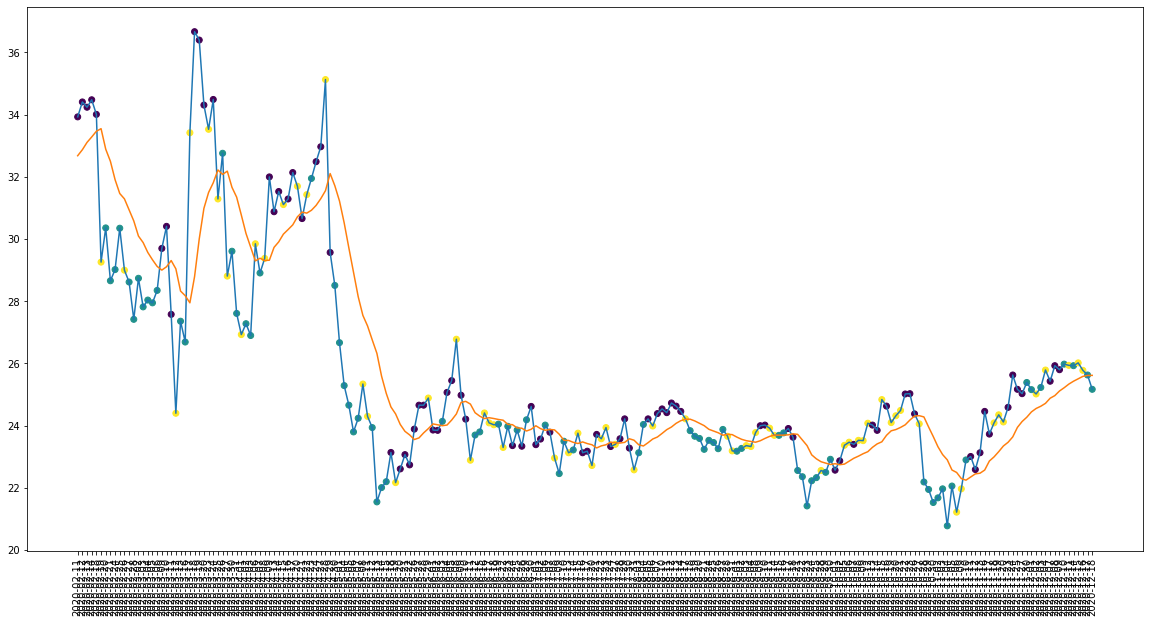

In [446]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

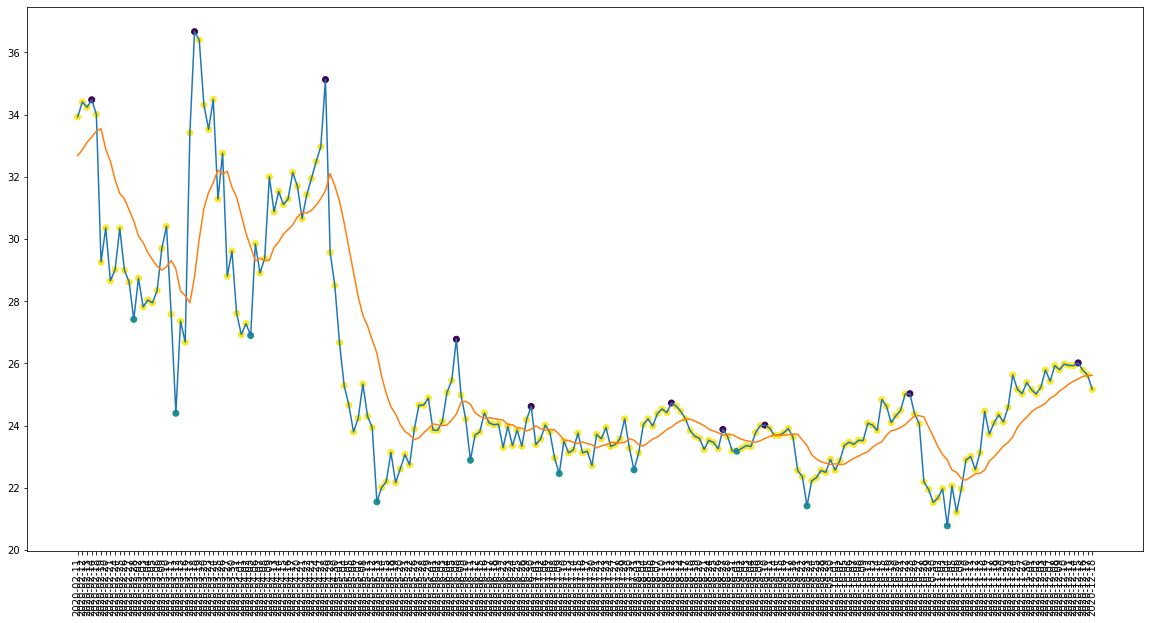

In [447]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [448]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 70
actual holds but predicted sell: 73
actual predicted holds: 56
Percentage buys correct: 70.0%
Percentage sells correct: 60.0%
Percentage holds correct: 28.14070351758794%
actual buys: 10
actual sells: 10
actual holds: 199


In [449]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 55.69620253164557%
Percentage holds correct: 79.03225806451613%


In [450]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $30.36000061035156
Shares owned at the moment: 328
Cash capital at the moment: $14.535079254152151


Stop Loss Activated!

Share price: $28.65999984741211
Shares owned at the moment: 0
Cash capital at the moment: $9389.163709342958


Share price: $28.65999984741211
Shares owned at the moment: 326
Cash capital at the moment: $20.310069223405662


Stop Loss Activated!

Share price: $27.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8934.648064026835


Share price: $27.420000076293945
Shares owned at the moment: 324
Cash capital at the moment: $26.13681923961849


Price increase from previously bought: 8.018051308215268%
Share price: $29.70000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9622.47436575222


Share price: $27.36000061035156
Shares owned at the moment: 350
Cash capital at the moment: $20.14015154171102


Price increase from previously bought: 33.660202538431385%
Share price: $36.66999816894531
Shares owned at the

In [451]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%
